### Task: Write a program in Python to detect the change from the images (Pre.jpg and Post.jpg) of the same location.

#### Important used packages and their versions
   - numpy==1.19.4
   - opencv-python==4.4.0.46
   - scikit-learn==0.23.2
   - scipy==1.1.0
   - matplotlib==3.3.3
   - notebook==6.1.5
   - python==3.7.9

We will be outlining an unsupervised method for change detection. It involves the automatic analysis of the change data, i.e. the **difference image**, constructed using the **multi temporal images**. A difference image is the pixel-by-pixel subtraction of the 2 images. **Eigen vectors** of pixel blocks from the difference image will then be extracted by **Principal Component Analysis** (PCA). Subsequently, a feature vector is constructed for each pixel in the difference image by projecting that pixel’s neighbourhood onto the Eigen vectors. The feature vector space, which is the collection of the feature vectors for all the pixels, upon clustering by K-means algorithm gives us two clusters – one representing pixels belonging to the changed class, and other representing pixels belonging to the unchanged class. Each pixel will belong to either of the clusters and hence a **change map** can be generated. So, the steps towards implementing this application are:

    1)Difference image generation and Eigen vector space (EVS)
    2)Building the feature vector space (FVS)
    
    3)Clustering of the feature vector space and change map

In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
# from scipy.misc import imresize
from scipy.misc import imread, imresize, imsave

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### 1. Difference image and the Eigen vector space

In this method,a non-overlapping blocks are taken  of size 5 x 5 from the difference image and flatten them into row vectors. The image can be resized to make both the dimensions a multiple of 5 by **scipy.misc.imresize()**. Collection of these row vectors forms a vector set. In change_detection.py script, find_vector_set() does exactly this. If the size of our difference image is m x n, then the number of rows in the vector set would be  **{m x n}/{5 x 5} .**

In [5]:
def find_vector_set(diff_image, new_size):
   
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))

    print('\nvector_set shape',vector_set.shape)
    
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                block   = diff_image[j:j+5, k:k+5]
                #print(i,j,k,block.shape)
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
        
            
    mean_vec   = np.mean(vector_set, axis = 0)    
    vector_set = vector_set - mean_vec
    
    return vector_set, mean_vec

### 2. Building the feature vector space

Building the FVS involves again taking 5 x 5 blocks from the difference image, flattening them, and lastly projecting them onto the EVS, only this time, the blocks will be overlapping. A vector space (VS) is first made by constructing one vector for each pixel of the difference image such a way that one 5 x 5 block is actually a pixel’s 5 x 5 neighborhood. It is to be noted here that by this logic, 4 boundary rows and 4 boundary columns pixels won’t get any feature vectors since they won’t have a 5 x 5 neighborhood. (We can manage with this exclusion of these pixels, since it is safe to assume here that any changes occurring would be concentrated in the middle regions of the images, rather than the edges). So, we will have **(m x n)- 8** feature vectors in the FVS, all 25 dimensional. Projecting the FVS to the **25 dimensional EVS** simply means to perform the following matrix multiplication

(VS)((m x n - 8) x 25) .(EVS)(25 x 25) = (FVS)(m x n - 8) x 25

Function **find_FVS()** determines the feature vector space for us. The function is similar to find_vector_set(), but extracts overlapping blocks from the difference image.

In [6]:
def find_FVS(EVS, diff_image, mean_vec, new):
    
    i = 2 
    feature_vector_set = []
    
    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
        
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("\nfeature vector space size",FVS.shape)
    return FVS

### 3. Clustering of the feature vector space, and change map

The feature vectors for the pixels carry information whether the pixels have characteristics of a changed pixel or an unchanged one. Having constructed the feature vector space, we now need to cluster it so that the pixels can be grouped into two disjoint classes. K-means algorithm is used to do that. Thus each pixel will get assigned to a cluster in such a way that the distance between the cluster’s mean vector and the pixel’s feature vector is the least. Each pixel gets a label from 1 to K, which denotes the cluster number that they belong to.

In [7]:
def clustering(FVS, components, new):
    
    kmeans = KMeans(components, verbose = 0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)

    least_index = min(count, key = count.get)            
    print(new[0],new[1])
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))
    
    return least_index, change_map

During this experiments, it was empirically found that the best results were obtained with K = 3. Thus the argument components in clustering() will be 3. Remember, even though we have to do divide the pixels into 2 categories, we have chosen K = 3, instead of 2. Now how do we decide which of these clusters contains the pixels that belong to the changed class? It can be postulated that the cluster which contains the lowest number of pixels (denoted by variable least_index) is the cluster denoting the changed class, since the background remains more or less the same in satellite images and the changes occurred are comparatively less. Also, the mean of this cluster will be the highest. The reason behind the highest value of mean for that cluster is that the values of the difference image pixels in a region where some changes have occurred are higher than the values of pixels in the regions where there is no change.

Thus, in conclusion, the cluster with the **lowest number of pixels**, and also the highest mean is the cluster belonging to the changed class.

With this information, we will now build a change map – a binary image to show the output of change detection. We have chosen to keep the background black and will show the changes in white, i.e., intensity value of those pixels will be 255. You can do the reverse as well.

In [8]:
def find_PCAKmeans(imagepath1, imagepath2):
    
    print('Operating')
    
    image1 = imread(imagepath1)
    image2 = imread(imagepath2)
    image1=image1[:,:,0]
    image2=image2[:,:,0]
    print(image1.shape,image2.shape) 
    new_size = np.asarray(image1.shape) / 5
    new_size = new_size.astype(int) * 5
    image1 = imresize(image1, (new_size)).astype(np.int16)
    image2 = imresize(image2, (new_size)).astype(np.int16)

    
    diff_image = abs(image1 - image2)   
    imsave('diff.jpg', diff_image)
    print('\nBoth images resized to ',new_size)
        
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    
    pca     = PCA()
    pca.fit(vector_set)
    EVS = pca.components_
        
    FVS     = find_FVS(EVS, diff_image, mean_vec, new_size)
    
    print('\ncomputing k means')
    
    components = 3
    least_index, change_map = clustering(FVS, components, new_size)
    
    change_map[change_map == least_index] = 255 ## change map formula
    change_map[change_map != 255] = 0
    
    change_map = change_map.astype(np.uint8)
    kernel     = np.asarray(((0,0,1,0,0),
                             (0,1,1,1,0),
                             (1,1,1,1,1),
                             (0,1,1,1,0),
                             (0,0,1,0,0)), dtype=np.uint8)
    cleanChangeMap = cv2.erode(change_map,kernel)
    imsave("changemap.jpg", change_map)
    imsave("cleanchangemap.jpg", cleanChangeMap)
 

In [9]:
if __name__ == "__main__":
 
    a="Post.jpg"
    b="Pre.jpg"

    find_PCAKmeans(a,b) 
    


Operating
(766, 1396) (766, 1396)

Both images resized to  [ 765 1395]

vector_set shape (42687, 25)


/home/drastraios/anaconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """
/home/drastraios/anaconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/home/drastraios/anaconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':
/home/drastraios/anaconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated i


feature vector space size (1058551, 25)

computing k means
765 1395


/home/drastraios/anaconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.
/home/drastraios/anaconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.


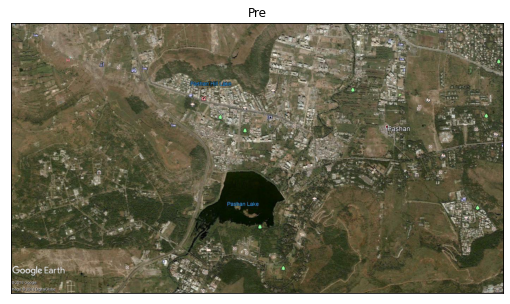

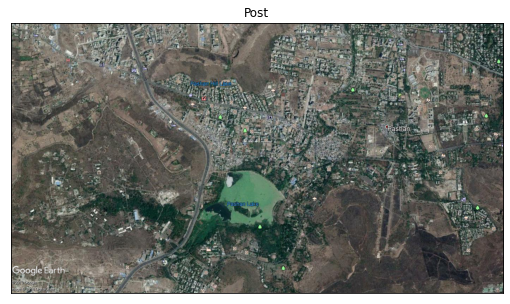

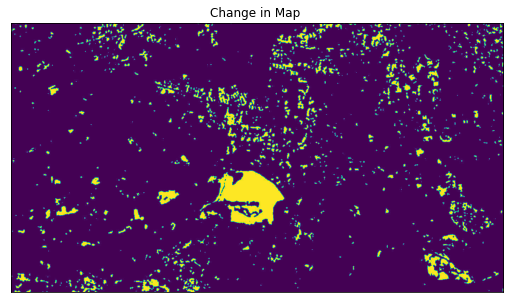

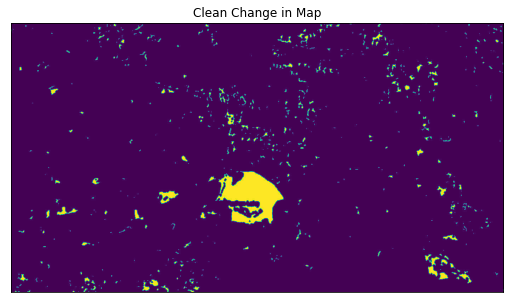

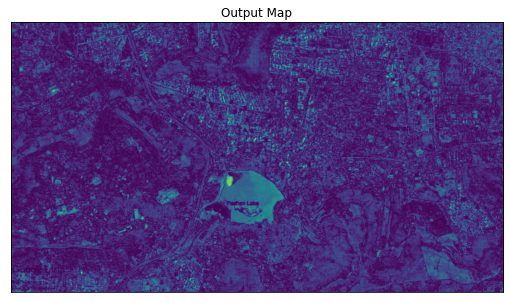

In [16]:


img1 = mpimg.imread('Pre.jpg')
img2 = mpimg.imread('Post.jpg')

img3 = mpimg.imread('changemap.jpg')
img4 = mpimg.imread('cleanchangemap.jpg')

img5 = mpimg.imread('diff.jpg')

titles = ['Pre', 'Post','Change in Map ','Clean Change in Map', 'Output Map']
images = [img1, img2, img3, img4,img5]

for i in range(5):
    plt.subplots(figsize=(30, 30))
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])

plt.show() 